# Spectra acquisiton
Control both the stepping motor and the camera from this notebook.<br>
Make a loop to measure a wide-range spectrum automatically.

NOTE: only one connection to COM port is possible at a time. Shut down other connections, either in python or dedicated software.

In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
import time, os, logging
from FLI import FLI
import numpy as np
import xarray as xr
from os.path import join
import datetime

In [3]:
%run thr640.py
%run imaging_tool.py

In [4]:
logger = logger
logger.setLevel(50) # 10 - DEBUG 50 - CRITICAL 20 - INFO
camera = FLI()
step_motor = THR640() # Can only have one instance.

SerialException: could not open port 'COM3': PermissionError(13, 'Access is denied.', None, 5)

In [25]:
basepath = r'\\10.249.254.51\Public\BACK_UP\kurokawa\data\spectrometer\20231128'
# basepath = r'C:\Users\fujii\Documents\python\kuzmin\kurokawa\20221111'
if not os.path.exists(basepath):
    os.makedirs(basepath)

In [6]:
ccw_limit = 0
cw_limit = 1030000

# Single

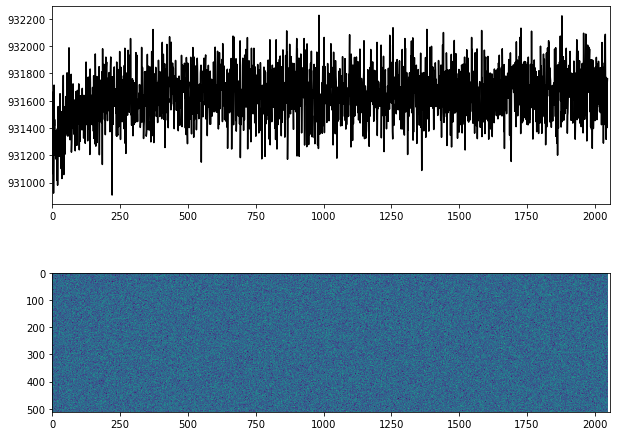

In [8]:
name=("H2O")
exposure = 1* 1e3 # ms
tag="10%"
# count=450000 # 615 nm
# count=740000 # 307.5 nm
# count=800000 # 226 nm
# count=100000 # 840 nm
# count=666000 # Hdelta
# count=644000 # Hgamma
# count=595000 # Hbeta
count=411000 # Halpha
# count=700000
# count=213000 # OI
# count=175000
# count = 0

step_motor.goto(count)
step_motor.waitUntilReady()
vbin = 1
attributes = {
    "temperature": camera.getTemperature(),
    "device_status": camera.getDeviceStatus(),
    "exposure": exposure,
    "frame_type": "light",
}
camera.setExposureTime(exposure);camera.setVBin(vbin);camera.setImageArea(10,0,2058,512//vbin);camera.exposeFrame()
time.sleep(.1)
# load image
image_data = camera.grabFrame(out=np.empty((512//vbin,2048), np.uint16))
# convert to xarray
data = xr.DataArray(
    image_data, dims=["y", "x"], coords={"image_counter": 0}, attrs=attributes
)
# save data as NetCDF file
filepath = join(basepath,f'{name}-{count}-{exposure}ms-{tag}.nc')
data.to_netcdf(filepath)
plot_image(image_data)

# LOOP

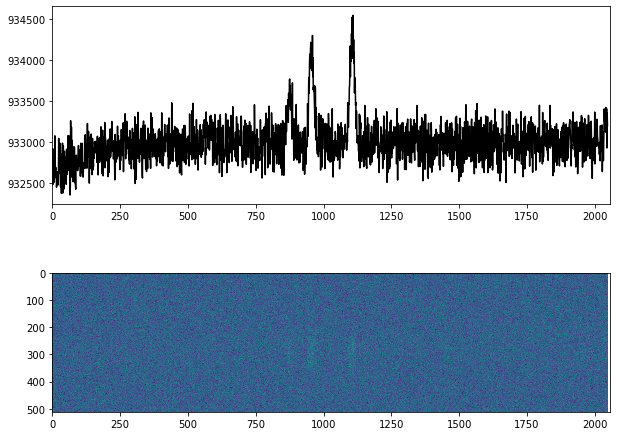

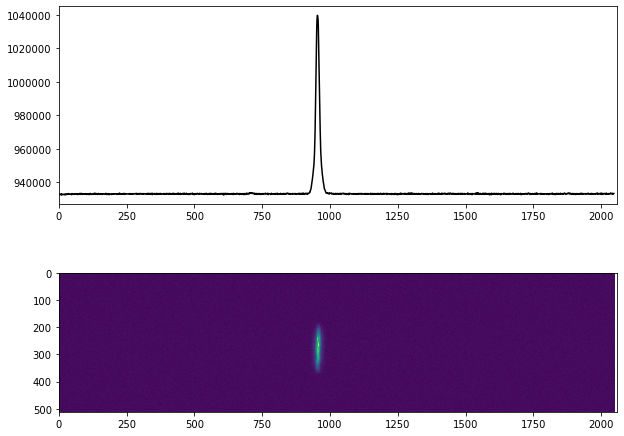

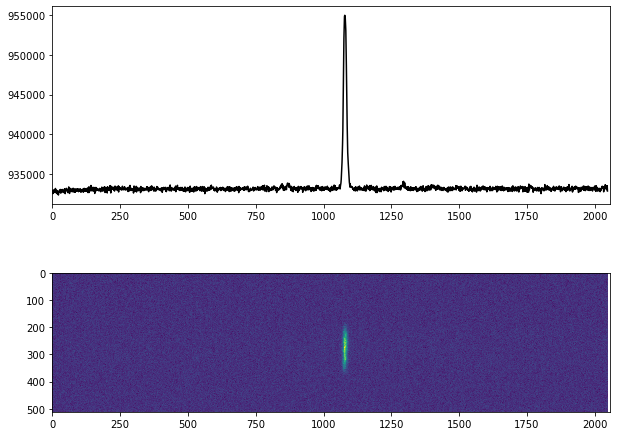

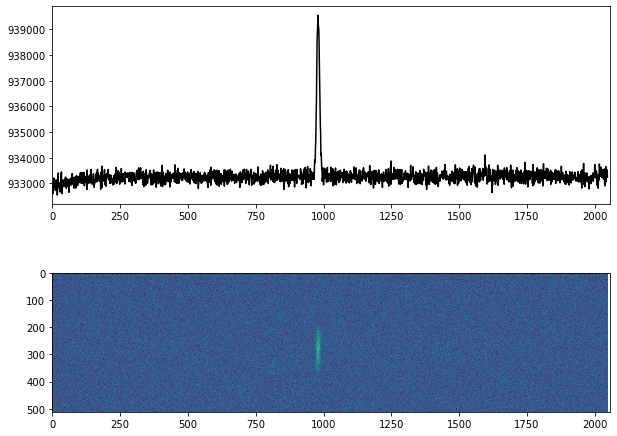

In [37]:
name=("H2O")
# name=("background")
# tag="cleaning"
tag="20%"
ampere = 3
# R = range(200000,805000,5000)
# R = [211000,212000,215000,216000]
R = [213000,411000,595000,644000]
# R = [635000+5000*i for i in range(5)]
# R = [180000,185000,195000]
# R = [500000+2000*i for i in range()]
# R = [(i+1)*5000 for i in range(200)]
# R = [420000]
# T = [60e3,10e3,60e3,60e3]
T = [1e3]*len(R)
# T = [60e3]*6
# T = [10e3]*4 #H2onlyloop
# T = [100e3,50e3,50e3,50e3] #H2O2loop
# T = [10e3]*100
hour=datetime.datetime.now().hour;minute=datetime.datetime.now().minute

for i in range(len(R)):
    if ccw_limit < R[i] < cw_limit:
        step_motor.goto(R[i]);step_motor.waitUntilReady();vbin = 1
        attributes = {
            "temperature": camera.getTemperature(),
            "device_status": camera.getDeviceStatus(),
            "exposure": T[i],
            "frame_type": "light",
        }
        camera.setExposureTime(T[i]);camera.setVBin(vbin);camera.setImageArea(10,0,2058,512//vbin);camera.exposeFrame()
        time.sleep(.1)
        
        image_data = camera.grabFrame(out=np.empty((512//vbin,2048), np.uint16)) # load image
        data = xr.DataArray(image_data, dims=["y", "x"], coords={"image_counter": 0}, attrs=attributes) # convert to xarray
        plot_image(image_data)
        # filepath = join(basepath,f'{name}-{R[i]}-{T[i]}ms-{ampere}A-{tag}-{hour}{minute}.nc')
        filepath = join(basepath,f'{name}-{R[i]}-{T[i]}ms-{hour}{minute}-{tag}.nc')
        data.to_netcdf(filepath) # save data as NetCDF file
    else:
        print("out of range")
        break

In [3]:
import sys
print(sys.getrecursionlimit())

sys.exit()

3000


SystemExit: 

c:\Users\fujii\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
